<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural - CEIA
## Alumno: Gonzalo Gontad
## Cohorte: 8va

## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [22]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Se utilizará como dataset el libro de Julio Verne "Viaje al Centro de la Tierra" en español.

In [23]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
#read files and concatenate to dataframe
df = pd.DataFrame()
df2 = pd.DataFrame()
for file in os.listdir("./libros/"):
    if file.endswith(".txt"):
        print (file)
        df2 = pd.read_csv('./libros/' + file,  sep='/n', header=None)
        df = pd.concat([df, df2], axis=0)


Julio Verne - Viaje al Centro de la Tierra.txt


/tmp/ipykernel_32110/12772139.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df2 = pd.read_csv('./libros/' + file,  sep='/n', header=None)


In [24]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2463


In [25]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

### 1 - Preprocesamiento completo
Se construira un corpus con todos los documentos concatenados uno despues de otro, se le aplicará un preprocesamiento de limpieza de caracter y tokenizacion y se contruyen los vectores de tokens para entrenamiento.

In [26]:
# Vistazo a las primeras filas
df.loc[100:115,0]

100    Cierto que la tal casa estaba un poco inclinad...
101    Mi tío, para profesor alemán, no dejaba de ser...
102    Confieso que me dediqué con gran entusiasmo a ...
103    En resumen, que vivía feliz en la casita de la...
104    En abril, cuando plantaba en los potes de loza...
105    Con tan original personaje, no tenía más remed...
106                                           Capítulo 2
107    Éste era un verdadero museo de mineralogía. To...
108    ¡Cuán familiares me eran aquellas chulerías de...
109    Pero cuando entré en el despacho, no podía lle...
110         —¡Qué libro! ¡Qué libro! —repetía sin cesar.
111    Estas exclamaciones me recordaron que el profe...
112    —¿No ves? —me dijo—, ¿no ves? Es un inestimabl...
113    —¡Magnífico! —exclamé yo, con simulado entusia...
114    En efecto, ¿a qué tanto entusiasmo por un viej...
115    Sin embargo, no cesaban las admirativas exclam...
Name: 0, dtype: object

In [27]:
import re
import unicodedata
import string

def preprocess_clean_text(text):   
    # pasar a minúsculas
    text = text.lower() 
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [28]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
# Preprocesamos el texto con las reglas para español
corpus = preprocess_clean_text(corpus)
corpus

'   viaje al centro de la tierra julio verne    textosinfo biblioteca digital abierta indice informacion capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  capitulo  autor otros textos texto num     titulo viaje al centro de la tierra autor julio verne etiquetas novela    editor edu robsy fecha de creacion  de mayo de  fecha de modificacion  de junio de     edita textosinfo    maison carree c ramal   alayor  menorca islas baleares espana    mas textos disponibles en httpswwwtextosinfo capitulo  el domingo  de mayo de  mi tio el profesor lidenbrock entro rapidamente a su hogar situado en el numero  de la 

In [29]:

# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['viaje',
 'al',
 'centro',
 'de',
 'la',
 'tierra',
 'julio',
 'verne',
 'textosinfo',
 'biblioteca',
 'digital',
 'abierta',
 'indice',
 'informacion',
 'capitulo',
 'capitulo',
 'capitulo',
 'capitulo',
 'capitulo',
 'capitulo']

In [30]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 71218


In [31]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [32]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['viaje', 'al', 'centro', 'de'],
 ['al', 'centro', 'de', 'la'],
 ['centro', 'de', 'la', 'tierra'],
 ['de', 'la', 'tierra', 'julio'],
 ['la', 'tierra', 'julio', 'verne'],
 ['tierra', 'julio', 'verne', 'textosinfo'],
 ['julio', 'verne', 'textosinfo', 'biblioteca'],
 ['verne', 'textosinfo', 'biblioteca', 'digital'],
 ['textosinfo', 'biblioteca', 'digital', 'abierta'],
 ['biblioteca', 'digital', 'abierta', 'indice'],
 ['digital', 'abierta', 'indice', 'informacion'],
 ['abierta', 'indice', 'informacion', 'capitulo'],
 ['indice', 'informacion', 'capitulo', 'capitulo'],
 ['informacion', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo'],
 ['capitulo', 'capitulo', 'capitulo', 'capitulo']]

In [33]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[118, 20, 167, 1],
 [20, 167, 1, 2],
 [167, 1, 2, 62],
 [1, 2, 62, 397],
 [2, 62, 397, 893],
 [62, 397, 893, 2898],
 [397, 893, 2898, 1011],
 [893, 2898, 1011, 4694],
 [2898, 1011, 4694, 1678],
 [1011, 4694, 1678, 2899],
 [4694, 1678, 2899, 4695],
 [1678, 2899, 4695, 67],
 [2899, 4695, 67, 67],
 [4695, 67, 67, 67],
 [67, 67, 67, 67],
 [67, 67, 67, 67],
 [67, 67, 67, 67],
 [67, 67, 67, 67],
 [67, 67, 67, 67],
 [67, 67, 67, 67]]

In [34]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 71214


### 2 - Input y target

In [35]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] 

print(x_data.shape)
print(y_data_int.shape)

(71214, 3)
(71214,)


In [36]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'que',
 4: 'el',
 5: 'y',
 6: 'a',
 7: 'en',
 8: 'no',
 9: 'un',
 10: 'se',
 11: 'las',
 12: 'los',
 13: 'por',
 14: 'del',
 15: 'mi',
 16: 'una',
 17: 'con',
 18: 'me',
 19: 'su',
 20: 'al',
 21: 'tio',
 22: 'mas',
 23: 'pero',
 24: 'lo',
 25: 'es',
 26: 'nos',
 27: 'sin',
 28: 'si',
 29: 'para',
 30: 'como',
 31: 'sus',
 32: 'este',
 33: 'esta',
 34: 'era',
 35: 'habia',
 36: 'yo',
 37: 'sobre',
 38: 'profesor',
 39: 'hans',
 40: 'mis',
 41: 'todo',
 42: 'le',
 43: 'hasta',
 44: 'despues',
 45: 'ni',
 46: 'vez',
 47: 'aquel',
 48: 'ya',
 49: 'pues',
 50: 'cuando',
 51: 'bien',
 52: 'dos',
 53: 'tan',
 54: 'mar',
 55: 'cual',
 56: 'ha',
 57: 'o',
 58: 'hacia',
 59: 'agua',
 60: 'solo',
 61: 'entonces',
 62: 'tierra',
 63: 'dijo',
 64: 'entre',
 65: 'usted',
 66: 'pies',
 67: 'capitulo',
 68: 'poco',
 69: 'aun',
 70: 'donde',
 71: 'nuestra',
 72: 'estas',
 73: 'tiempo',
 74: 'muy',
 75: 'ser',
 76: 'axel',
 77: 'porque',
 78: 'menos',
 79: 'fin',
 80: 'gran',
 8

In [37]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10861

In [38]:
#y_data_int comienza en "1" en vez de "0"
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(71214, 10861)

### 3 - Entrenar el modelo

In [39]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [40]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

10861

In [41]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 10861 palabras distintas
# output_dim = 11
model.add(Embedding(input_dim=vocab_size+1, output_dim=11, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 11)             119482    
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             19456     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10861)             358413    
                                                                 
Total params: 532,455


2023-06-14 09:03:55.375854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 09:03:55.376817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 09:03:55.378010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Trainable params: 532,455
Non-trainable params: 0
_________________________________________________________________


In [42]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50


2023-06-14 09:03:55.648584: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2475048124 exceeds 10% of free system memory.
2023-06-14 09:03:57.762099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 09:03:57.763546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 09:03:57.765882: I tensorflow/core/common_runtime/executor.cc:1197] [/de

1777/1781 [============================>.] - ETA: 0s - loss: 7.2145 - accuracy: 0.0584

2023-06-14 09:04:24.346140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 618772892 exceeds 10% of free system memory.
2023-06-14 09:04:24.946669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 09:04:24.949166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 09:04:24.951160: I tensorflow/core/common_runtime/executor.cc:1197] [/dev

1781/1781 [==============================] - 30s 15ms/step - loss: 7.2139 - accuracy: 0.0585 - val_loss: 7.1311 - val_accuracy: 0.0642
Epoch 2/50
1781/1781 [==============================] - 26s 15ms/step - loss: 6.7246 - accuracy: 0.0596 - val_loss: 7.1615 - val_accuracy: 0.0732
Epoch 3/50
1781/1781 [==============================] - 26s 15ms/step - loss: 6.5076 - accuracy: 0.0737 - val_loss: 7.1704 - val_accuracy: 0.0843
Epoch 4/50
1781/1781 [==============================] - 26s 15ms/step - loss: 6.2685 - accuracy: 0.0809 - val_loss: 7.2015 - val_accuracy: 0.0844
Epoch 5/50
1781/1781 [==============================] - 27s 15ms/step - loss: 6.0633 - accuracy: 0.0846 - val_loss: 7.3086 - val_accuracy: 0.0841
Epoch 6/50
1781/1781 [==============================] - 26s 15ms/step - loss: 5.8951 - accuracy: 0.0886 - val_loss: 7.5734 - val_accuracy: 0.0839
Epoch 7/50
1781/1781 [==============================] - 26s 15ms/step - loss: 5.7477 - accuracy: 0.0927 - val_loss: 7.6612 - val_accura

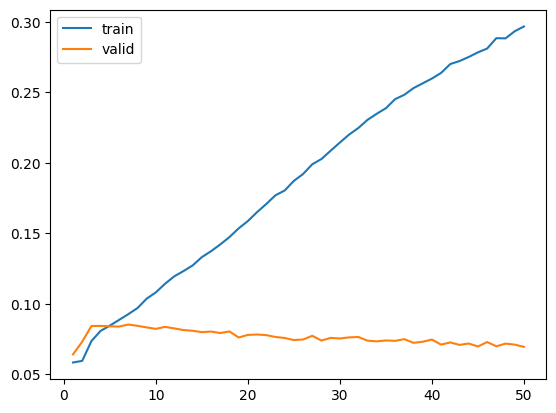

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 4 - Predicción de próxima palabra

In [45]:
# Se utilizará gradio para ensayar el modelo
import sys
!{sys.executable} -m pip install gradio --quiet

In [46]:
import gradio as gr

def model_response(human_text):
    # Preprocesamos el texto con las reglas para español
    human_text = preprocess_clean_text(human_text)
    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/home/gonzalo/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gonzalo/anaconda3/envs/nlp/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)



Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


2023-06-14 09:37:46.328124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 09:37:46.330766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 09:37:46.332906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 20ms/step
Keyboard interruption in main thread... closing server.


### 5 - Generación de secuencias nuevas

In [47]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = preprocess_clean_text(seed_text)
	# generate a fixed number of words
    for _ in range(n_words):

		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [53]:
sentences=['las calles mas tradicionales del barrio antiguo de hamburgo',
'la pequena habitacion del piso alto que utilizaba como dormitorio',
'sus grandes ojos observaban a todas partes detras de sus amplias gafas',
'sera sin duda alguna traduccion alemana']
for sentence in sentences:
    print (f'{sentence} \n--> {generate_seq(model, tok, sentence, max_length=3, n_words=2)}')

    #print (generate_seq(model, tok, sentence, max_length=3, n_words=10))

1/1 [==============================] - 0s 21ms/step
las calles mas tradicionales del barrio antiguo de hamburgo 
--> las calles mas tradicionales del barrio antiguo de hamburgo iguales 
1/1 [==============================] - 0s 16ms/step
la pequena habitacion del piso alto que utilizaba como dormitorio 
--> la pequena habitacion del piso alto que utilizaba como dormitorio en la
1/1 [==============================] - 0s 20ms/step
sus grandes ojos observaban a todas partes detras de sus amplias gafas 
--> sus grandes ojos observaban a todas partes detras de sus amplias gafas exclamar nos
1/1 [==============================] - 0s 20ms/step
sera sin duda alguna traduccion alemana 
--> sera sin duda alguna traduccion alemana mi al


### 7 - Conclusiones

El modelo tiene una un desempeño muy bajo. Se puede ver que el accuracy de test crece en cada epoca, pero el de validacion deja de crecer en la epoca 7 y luego decrece. Esto es un claro indicio de overfitting.

Se podria mejorar el modelo si se utilizara un dataset mas grande, o si se utilizara un embedding pre-entrenado.